***| Cristian Meichtry (62529) | Juan Martin Rodriguez (62563) |*** 

Luego de iterar sobre varios diseños, se probaron dos modelos principales:

***Primer modelo***: Consta de 4 bloques convolucionales y capas densas finales. Utiliza activaciones SELU, Batch Normalization, Dropout, ruido gaussiano y regularización L2. Optimiza con Adam y clasifica con softmax. Obtuvo un score privado de 0.6954 y un score público de 0.7108.

***Segundo modelo***: Es una red residual profunda con bloques que integran convoluciones, Batch Normalization y conexiones residuales. Incluye etapas de inicialización, procesamiento intermedio y reducción espacial, seguidas de capas densas con Swish y regularización. También utiliza Adam como optimizador. Este modelo logró un score privado de 0.6766 y un score público de 0.6808.

Por otro lado, se observó que, de manera contraintuitiva, al aplicar data augmentation similar al del TP1, el rendimiento disminuía notablemente, alcanzando scores cercanos a 0.58.

In [26]:
import numpy as np # linear algebra

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dl-itba-cifar-100-2024-q-1/y_train_fine.npy
/kaggle/input/dl-itba-cifar-100-2024-q-1/y_train_coarse.npy
/kaggle/input/dl-itba-cifar-100-2024-q-1/fine_label_names.pck
/kaggle/input/dl-itba-cifar-100-2024-q-1/coarse_label_names.pck
/kaggle/input/dl-itba-cifar-100-2024-q-1/x_test.npy
/kaggle/input/dl-itba-cifar-100-2024-q-1/x_train.npy


In [27]:
x_train = np.load("/kaggle/input/dl-itba-cifar-100-2024-q-1/x_train.npy")/255.
x_test = np.load("/kaggle/input/dl-itba-cifar-100-2024-q-1/x_test.npy")/255.
y_train_coarse = np.load("/kaggle/input/dl-itba-cifar-100-2024-q-1/y_train_coarse.npy")
y_train_fine = np.load("/kaggle/input/dl-itba-cifar-100-2024-q-1/y_train_fine.npy")

print(y_train_coarse)
print(y_train_fine)

[11 15  4 ...  8  7  1]
[19 29  0 ...  3  7 73]


In [28]:
import pickle

with open("/kaggle/input/dl-itba-cifar-100-2024-q-1/fine_label_names.pck", "rb") as f:
    labels_fine = pickle.load(f)
with open("/kaggle/input/dl-itba-cifar-100-2024-q-1/coarse_label_names.pck", "rb") as f:
    labels_coarse = pickle.load(f)

In [29]:
from matplotlib import pyplot as plt
#%load_ext tensorboard
import keras_cv

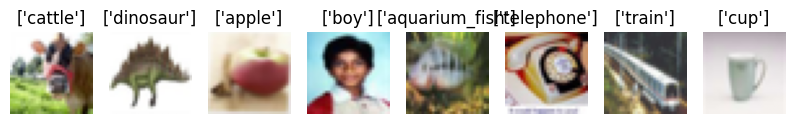

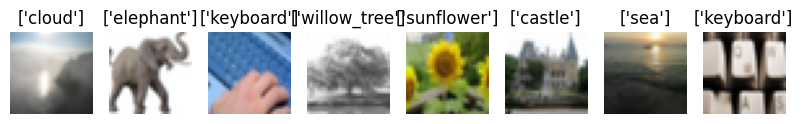

In [30]:
#This code snippet visualizes samples from the training dataset.
#It displays two rows of images with their corresponding labels, each consisting of eight images.

plt.figure(figsize=(10, 10))
cant = 8
for i in range(cant):
    plt.subplot(1, cant, i+1)
    plt.imshow(x_train[i]) #Display the i-th image from the training set
    plt.title([labels_fine[y_train_fine[i]] ])
    plt.axis('off')
plt.show()
plt.figure(figsize=(10, 10))

for i in range(cant):
    plt.subplot(1, cant, i+1)
    plt.imshow(x_train[i+cant]) #Display the image at index i + cant in x_train
    plt.title([labels_fine[y_train_fine[i+cant]]])
    plt.axis('off')

In [31]:
len(x_train) 

50000

In [32]:
x_train[0].ndim

3

In [33]:
from sklearn.model_selection import train_test_split
x_split_train, x_split_val, y_split_train, y_split_val = train_test_split(x_train, y_train_fine, test_size=0.2, stratify=y_train_fine)

In [34]:
print(len(x_split_train))
print(len(x_split_val))
print(len(y_split_train))
print(len(y_split_val))

40000
10000
40000
10000


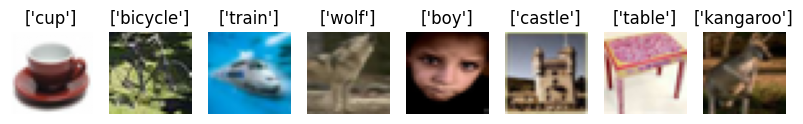

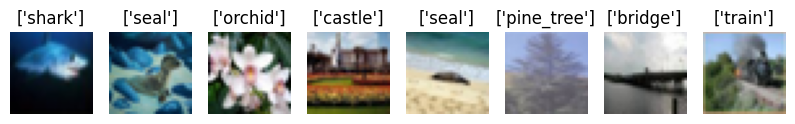

In [35]:
plt.figure(figsize=(10, 10))
cant = 8
for i in range(cant):
    plt.subplot(1, cant, i+1)
    plt.imshow(x_split_train[i]) #Display the i-th image from the training set
    plt.title([labels_fine[y_split_train[i]] ])
    plt.axis('off')
plt.show()
plt.figure(figsize=(10, 10))

for i in range(cant):
    plt.subplot(1, cant, i+1)
    plt.imshow(x_split_train[i+cant]) #Display the image at index i + cant in x_split_train
    plt.title([labels_fine[y_split_train[i+cant]]])
    plt.axis('off')

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GaussianNoise, BatchNormalization, Flatten, Input, Rescaling, Conv2D, Conv1D, MaxPooling1D, MaxPooling2D, Normalization, RandomBrightness, RandomFlip, RandomContrast, RandomFlip, RandomRotation, RandomCrop
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.initializers import RandomNormal, Constant
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt

In [37]:
model = Sequential()
model.add(Input((32,32,3)))
model.add(Normalization())
branch = Sequential()

model.add(Conv2D(128, 3, padding="same", activation="selu"))
model.add(BatchNormalization())
model.add(Conv2D(128, 3, padding="same", activation="selu"))
model.add(BatchNormalization())
model.add(Conv2D(128, 3, padding="same", activation="selu"))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.3))

model.add(GaussianNoise(0.3))


model.add(Conv2D(256, 3, padding="same", activation="selu", kernel_regularizer=L2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(256, 3, padding="same", activation="selu", kernel_regularizer=L2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(256, 3, padding="same", activation="selu", kernel_regularizer=L2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.35))

model.add(GaussianNoise(0.3))

model.add(Conv2D(512, 3, padding="same", activation="selu", kernel_regularizer=L2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(512, 3, padding="same", activation="selu", kernel_regularizer=L2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(512, 3, padding="same", activation="selu", kernel_regularizer=L2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.4))

model.add(GaussianNoise(0.3))

model.add(Conv2D(1024, 3, padding="same", activation="selu", kernel_regularizer=L2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(1024, 3, padding="same", activation="selu", kernel_regularizer=L2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(1024, 3, padding="same", activation="selu", kernel_regularizer=L2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.5))

model.add(GaussianNoise(0.2))

model.add(Flatten())

model.add(Dense(1024, activation="selu", kernel_regularizer=L2(1e-4)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(512, activation="selu", kernel_regularizer=L2(1e-4)))
model.add(Dropout(0.4))
model.add(BatchNormalization(momentum=0.95, 
        epsilon=0.005,
        beta_initializer=RandomNormal(mean=0.0, stddev=0.05), 
        gamma_initializer=Constant(value=0.9)))
model.add(Dense(100, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ["accuracy"], optimizer = Adam(learning_rate=0.001))

In [38]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 32, 32, 3)      │             7 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise (GaussianNoise)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_1                │ (None, 8, 8, 256)      │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │             

 Total params: 36,070,507 (137.60 MB)

 Trainable params: 36,055,908 (137.54 MB)

 Non-trainable params: 14,599 (57.03 KB)

In [39]:
# Sets up learning rate reduction on plateau to optimize training stability.

rlrop = ReduceLROnPlateau(
    monitor="val_accuracy",  # Monitors validation accuracy to detect plateaus
    factor=0.5,              # Reduces the learning rate by half when plateauing
    patience=3,              # Waits for 3 epochs without improvement before reducing the learning rate
    verbose=1,               # Enables detailed output for each reduction in learning rate
    min_lr=1e-5              # Defines a minimum learning rate to prevent over-reduction
)

In [40]:
# Sets up a model checkpoint to save the best weights during training.

mc = ModelCheckpoint(
    "best_weights.weights.h5",   # Path to save the model weights file.
    monitor="val_accuracy",      # Monitors validation accuracy to determine when to save
    verbose=1,                   # Prints a message each time the model weights are saved
    save_best_only=True,         # Saves only if validation accuracy improves, keeping the best weights
    save_weights_only=True       # Saves only the model weights, not the full model
)

In [41]:
# Sets up early stopping to monitor the validation accuracy during training.

es = EarlyStopping(
    monitor="val_accuracy",       # Tracks validation accuracy to determine stopping point
    patience=10,                  # High patience value (40 epochs) to enable longer training
    verbose=1,                    # Prints messages to indicate when early stopping is triggered
    restore_best_weights=True     # Restores model weights from the best validation accuracy epoch
)

In [42]:
tb = TensorBoard(
    log_dir="logs",
)

In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
            featurewise_center=False,  
            samplewise_center=False,  
            featurewise_std_normalization=False,  
            samplewise_std_normalization=False,  
            zca_whitening=False, 
            rotation_range=0,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            vertical_flip=False)

datagen.fit(x_split_train)

In [44]:
# Trains the model using the fit method and logs the training history.

history = model.fit(
    datagen.flow(x_split_train, y_split_train, batch_size=64),
    steps_per_epoch=x_split_train.shape[0]//50,                               
    epochs=100,                                     # Specifies the maximum number of training epochs.
    validation_data=(x_split_val, y_split_val),       # Uses validation set to track the model’s performance.
    callbacks=[                                     
        rlrop,  # Reduces learning rate on plateau if validation performance stops improving
        es,     # Implements early stopping with patience, restoring the best weights
        mc,     # Saves the model weights when the best validation accuracy is reached
        tb,     # Enables tensorboard logging for visualizing the training process
    ]
)


Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732918888.844037      80 service.cc:145] XLA service 0x79771800c8f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732918888.844129      80 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1732918911.499152      80 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_7', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill 

625/800 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.0418 - loss: 5.3651

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_accuracy improved from -inf to 0.09550, saving model to best_weights.weights.h5
800/800 ━━━━━━━━━━━━━━━━━━━━ 76s 56ms/step - accuracy: 0.0457 - loss: 5.3046 - val_accuracy: 0.0955 - val_loss: 4.6831 - learning_rate: 0.0010
Epoch 2/100
625/800 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.1038 - loss: 4.5353
Epoch 2: val_accuracy improved from 0.09550 to 0.12440, saving model to best_weights.weights.h5
800/800 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.1064 - loss: 4.5101 - val_accuracy: 0.1244 - val_loss: 4.4356 - learning_rate: 0.0010
Epoch 3/100
625/800 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.1475 - loss: 4.1276
Epoch 3: val_accuracy improved from 0.12440 to 0.16330, saving model to best_weights.weights.h5
800/800 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.1491 - loss: 4.1178 - val_accuracy: 0.1633 - val_loss: 4.0665 - learning_rate: 0.0010
Epoch 4/100
625/800 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.1842 - loss: 3.9222
Epoch 4: val_accur

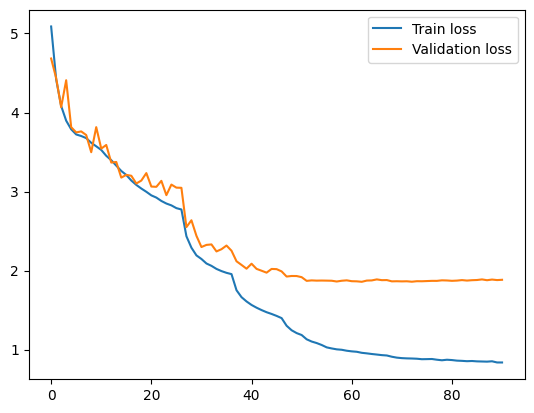

In [45]:
plt.plot(history.history["loss"], label="Train loss")

plt.plot(history.history["val_loss"], label="Validation loss")

plt.legend()

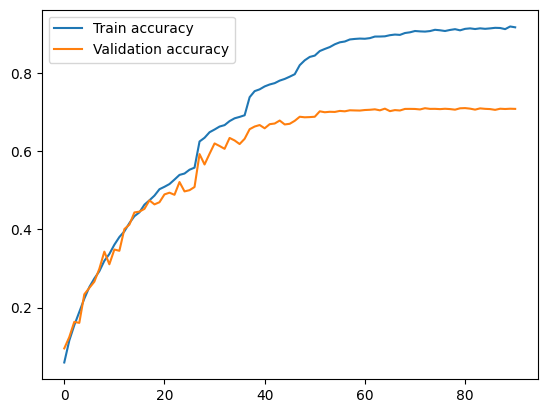

In [46]:
plt.plot(history.history["accuracy"], label="Train accuracy")

plt.plot(history.history["val_accuracy"], label="Validation accuracy")

plt.legend()

In [47]:
predictions = model.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step


In [48]:
predictions = predictions.argmax(axis=1)

In [49]:
predictions

array([68, 33, 55, ..., 51, 42, 70])

In [50]:
df = pd.DataFrame(predictions, columns=["Label"])

In [51]:
df.index.name = "Id"

In [52]:
df.head()

,Label
Id,
0,68
1,33
2,55
3,51
4,71


In [53]:
df.to_csv("submission.csv")